In [92]:
# test file implementation of regularization of damage (d) using lipschitz constraints
import numpy as np
import scipy
import copy
from sortedcontainers import SortedList
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from itertools import groupby
from operator import itemgetter

In [93]:
# Material parameters
E = 275.0*10**9     # Young's module (Pa)
Gc = 50.0          # Fracture energy

# Geometry parameters
L = 1.05*10**-3     # Bar length
x0 = 0              # Left extremitiy x coordinate / 0-initial
xf = L              # Rigth extremitiy x coordinate / f-final

# Mesh
n_el = 21           # Number of elements
hun = L/n_el        # Element length
# Points coordinates for a uniform mesh
node_coord = np.linspace(x0, xf, n_el+1)
# Coordenates of integration points
x = [hun*i + hun*0.5 for i in range(n_el)]

# Data for test damage peak at the middle of the bar
# A fabricated damage field
dn = [0., 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574,  0.24024,  0.247944,0.250687, 0.248469, 0.24129,  0.229149, 0.212047, 0.189984, 0.16296, 0.127299, 0.0898275, 0.0473944, 0.]
# dsym =( np.array(dn) + np.array(dn[ : : -1])) * 0.5
# dn = dsym

# A fabricate critical stress field
stress_critical = 300.0*10**4
sigmac = [(abs(node_coord[i]-L/2)**0.5)/((L/2)**0.5 /
                                         (stress_critical*3)) + stress_critical for i in range(n_el)]

# sigmac_sym =( np.array(sigmac) + np.array(sigmac[ : : -1])) * 0.5
# sigmac = sigmac_sym
strain = np.zeros(n_el)
for el in range(n_el):
    strain[el] = 5*10**-5  # Assuming constant strain

In [94]:
# Regularization inputs
# n_element_reg = 10              # Nb elem in the reg length
n_element_reg = 10              # Nb elem in the reg length
l = n_element_reg * hun  # Regularization length
w = 2.0  # Weight quadrature

# Energy release rate
Yc = [sigmac[el] ** 2 / (2.0 * E) for el in range(n_el)]

# Constant lambda
lamb = [2.0 * Yc[el] * l / Gc for el in range(n_el)]


if max(lamb) > 1./3.:
    raise Exception("lambda > 1/3 -> h(d) not convex!")

# Softening function (h)
def h(lamb, d):
    return (2.0 * d - d**2) / (1.0 - d + lamb * d**2) ** 2


In [95]:
def getFunctional(strain):
    """Returns a lambda function of damage to be use in the optimization problem for the whole domain.\n
    Arguments: \n
    strain -- strain computed using the displacement at the next time-step(n+1)."""

    functional_whole_domain = lambda damage: w * sum(
        [
            (0.5 * (1.0 - damage[el]) ** 2 * E * strain[el] ** 2
            + Yc[el] * h(lamb[el], damage[el]))
            * hun
            * 0.5
            for el in range(n_el)
        ]
    )

    return functional_whole_domain


def getFunctionalSubdomain(strain, region_optimization):
    """Returns a lambda function of damage to be use in the optimization problem for a specific region in the domain (subdomain).\n
    Arguments: \n
    strain -- strain computed using the displacement at the next time-step(n+1).\n
    region -- an array with the element indexes of the subdomain to compute damage at next time-step(n+1)."""

    functional_subdomain = lambda damage: w * sum(
        [
            (
                0.5
                * (1.0 - damage[i]) ** 2
                * E
                * strain[region_optimization[i]] ** 2
                + Yc[region_optimization[i]]
                * h(lamb[region_optimization[i]], damage[i])
            )
            * hun
            * 0.5
            for i in range(len(region_optimization))
        ]
    )

    return functional_subdomain

In [96]:
def computeDamagePredictor(strain, damage_previous_step):
    """Returns an array with the damage predictor for the whole domain."""

    functional = getFunctional(strain)

    damage_predictor_opt = minimize(
        fun=functional,
        x0=damage_previous_step,
        method="SLSQP",
        bounds=zip(damage_previous_step, [1.0] * n_el),
        tol=1e-10,
    )
    if damage_predictor_opt.success == False:
        raise Exception("optimization damage predictor failed")

    damage_predictor = damage_predictor_opt.x
    # print(damage_predictor_opt)

    return damage_predictor

In [97]:
# def computeDamagePredictorNewton(damage_previous_step):

#     dp = np.zeros(len(damage_previous_step))

#     first_derivative_g = lambda damage: - 2. * (1 - damage) 
#     second_derivative_g = 2. 

#     def derivatives_h(damage, lamb_const, derivative):
#         first_derivative_h =  (2. + 2. * (-3. + damage) * damage**2 * lamb_const) / (1. + damage * (-1. + damage * lamb_const))**3 
#         second_derivative_h = (6. + 6.*damage*lamb_const*(-4. + damage)*damage**2*lamb_const)/ (1. + damage * (-1. + damage*lamb_const)) 
#         if derivative == 1:
#             return first_derivative_h 
#         if derivative == 2:
#             return second_derivative_h

#     first_derivative = [0.5 * first_derivative_g(damage_previous_step[i]) * E * strain[i] ** 2 + Yc[i] * derivatives_h(dn[i], lamb[i], 1) for i in range(n_el)] 

#     second_derivative = [0.5 * second_derivative_g * E * strain[i] ** 2 + Yc[i] * derivatives_h(dn[i], lamb[i], 2) for i in range(n_el)] 

#     d_previous = damage_previous_step.copy()

#     for i in range(len(damage_previous_step)):
#         dp[i] = damage_previous_step[i] - first_derivative[i] / second_derivative[i]    
#     dp = np.clip(dp, damage_previous_step, 1)

#     n_interrupt = 0
#     n_max_interations = 10
#     error = 1e-10
#     norm_resid = np.linalg.norm(dp - d_previous) / np.sqrt(n_el)

#     while n_interrupt < n_max_interations and norm_resid > error:

#         n_interrupt += 1
#         d_previous = dp


#         first_derivative = [0.5 * first_derivative_g(dp[i]) * E * strain[i] ** 2 + Yc[i] * derivatives_h(dp[i], lamb[i], 1) for i in range(n_el)] 

#         second_derivative = [0.5 * second_derivative_g * E * strain[i] ** 2 + Yc[i] * derivatives_h(dp[i], lamb[i], 2) for i in range(n_el)] 

#         for i in range(len(damage_previous_step)):
#             dp[i] = dp[i] - first_derivative[i] / second_derivative[i] 
#         dp = np.clip(dp, damage_previous_step, 1)
#         norm_resid = np.linalg.norm(dp - d_previous) / np.sqrt(n_el)
#         print(norm_resid)
    
        
#     return dp


def getGradFunctional(damage, lamb_const):
    
    first_derivative_g = [- 2. * (1. - damage[i]) for i in range(len(damage))]

    first_derivative_h =  [(2. + 2. * (-3. + damage[i]) * damage[i]**2 * lamb_const[i]) / (1. + damage[i] * (-1. + damage[i] * lamb_const[i]))**3  for i in range(len(damage))]

    grad =[ 0.5 * first_derivative_g[i] * E * strain[i] ** 2 + Yc[i] * first_derivative_h[i] for i in range(len(damage))]

    return grad


def getHessFunctional(damage, lamb_const):

    second_derivative_g = 2.
    second_derivative_h = [(6. + 6.*damage[i]*lamb_const[i]*(-4. + damage[i])*damage[i]**2*lamb_const[i])/ (1. + damage[i] * (-1. + damage[i]*lamb_const[i]))**4 for i in range(len(damage))]

    hess = [0.5 * second_derivative_g * E * strain[i] ** 2 + Yc[i] * second_derivative_h[i] for i in range(len(damage))]

    return hess


def computeDamagePredictorNewton(damage_previous_step):

    dp = np.zeros(len(damage_previous_step))
    dn = damage_previous_step.copy()
    grad = np.zeros(len(dp))
    hess = np.zeros(len(dp))
    d_previous = damage_previous_step.copy()

    grad = np.array(getGradFunctional(dn, lamb))
    hess = np.array(getHessFunctional(dn, lamb))

    dp = dn - grad / hess
    dp = np.clip(dp, damage_previous_step, 1)

    n_interrupt = 0
    n_max_interations = 10
    error = 1e-5
    norm_residual = np.linalg.norm(dp - d_previous) / np.sqrt(n_el)

    while n_interrupt < n_max_interations and norm_residual > error:

        n_interrupt += 1
        d_previous = dp.copy()

        grad = np.array(getGradFunctional(d_previous, lamb))
        hess = np.array(getHessFunctional(d_previous, lamb))

        dp = d_previous - grad / hess
        dp = np.clip(dp, damage_previous_step, 1)

        norm_residual = np.linalg.norm(dp - d_previous) / np.sqrt(n_el)
        # print('n_interrupt = ',n_interrupt)
        # print('dprevious=', d_previous)
        # print('dp=', dp)
    print('n_interrupt = ',n_interrupt)
    if norm_residual > error:
        print('No convergence')
        print(norm_residual)
        
    return dp


In [98]:
def computeProjectionsOpt(damage_prediction):
    """Returns the damage prediction upper and lower projections."""

    lower = np.zeros(n_el)
    upper = np.zeros(n_el)

    for el in range(n_el):
        upper_opt = minimize(
            lambda y: -damage_prediction[np.searchsorted(node_coord, y[0]) - 1]
            + abs(x[el] - y[0]) / l,
            x0=0.,
            method="SLSQP",
            bounds=[(x0, xf)],
            tol=1e-5
        )
        if upper_opt.success == False:
            raise Exception("upper projection of damage predictor failed")
        upper[el] = -upper_opt.fun
        

        lower_opt = minimize(
            lambda y: damage_prediction[np.searchsorted(node_coord, y[0])-1] + abs(x[el]-y[0])/l,
            x0=0.,
            method='SLSQP',
            bounds=[(x0, xf)],
            tol=1e-5
        )
        if lower_opt.success == False:
            raise Exception('lower projection damage predictor failed')
        lower[el] = lower_opt.fun


    return upper, lower

In [99]:
def get_neighbour(index):
    if index == 0:
        return [0]
    if index == n_el - 1:
        return [index - 1]
    return [index - 1, index + 1]


def computeProjectionsUsingFM_lip_projector_1D(damage_predictor, regularization_lenght, flank):
    
    # Let's assume initially the projection equal to the damage predictor
    projection = damage_predictor.copy()
    slope_limit = 1. / regularization_lenght
    # Configure key for trial set according to the projection if upper (flank=max) or lower (flank=min)
    if flank == "min":
        trial_set = SortedList(key=lambda x: (-x[0], x[1]))
    else:
        trial_set = SortedList()

    # Add all elements to the trial set
    for index, projection_value in enumerate(projection):
        trial_set.add((projection_value, index))

    # Initialize the frozen set 
    frozen_set = set()

    while len(trial_set) > 0:

        projection_current_index, index = trial_set.pop()
        frozen_set.add(index)
        neighbours = get_neighbour(index)

        for index_neighbour in neighbours:
            if index_neighbour not in frozen_set:      
                update_projection_value = False

                delta_projection = (projection[index_neighbour] - projection_current_index) / hun 

                if delta_projection < -slope_limit:
                    update_projection_value = True
                    new_projection = projection_current_index - hun /  regularization_lenght

                elif delta_projection > slope_limit:
                    update_projection_value = True
                    new_projection = projection_current_index + hun / regularization_lenght

                if update_projection_value == True:
                    trial_set.discard((projection[index_neighbour], index_neighbour))
                    trial_set.add((new_projection, index_neighbour))
                    projection[index_neighbour] = new_projection

    return projection

In [100]:
def computePorjectionsMinMax(damage_predictor, flank):
    
    projection = damage_predictor.copy()
    # Configure key for trial set according to the projection if upper (flank=max) or lower (flank=min)
    if flank == "min":
        trial_set = SortedList(key=lambda x: (-x[0], x[1]))
    else:
        trial_set = SortedList()

    # Add all elements to the trial set
    for index, projection_value in enumerate(projection):
        trial_set.add((projection_value, index))

    # Initialize the frozen set 
    frozen_set = set()


    while len(trial_set) > 0:

        projection_current_index, index = trial_set.pop()
        frozen_set.add(index)
        neighbours = get_neighbour(index)

        for index_neighbour in neighbours:
            if index_neighbour not in frozen_set: 
                if flank == "max":
                    new_projection = max(projection_current_index - hun/l , projection[index_neighbour] )

                else:
                    new_projection = min(projection_current_index + hun/l , projection[index_neighbour] )

                if new_projection - projection[index_neighbour] < 10e-5:
                    trial_set.discard((projection[index_neighbour], index_neighbour))
                    trial_set.add((new_projection, index_neighbour))
                    projection[index_neighbour] = new_projection
        
    return projection

In [101]:
def computeDamageLipConstraint(strain, region_optimization, dn, upper, lower):
    """Returns an array with the damage at the next time-step for one subdomain imposing the Lipischitz constraint.\n
    Arguments:
    strain -- array with the strain for next time-step for all the elements;\n
    region_optimization -- an array with the indexes of elements in one subdomain; \n
    dn -- damage for all of the domain at time-step (n)."""

    functional = getFunctionalSubdomain(strain, region_optimization)
    # Size of the domain
    size = len(region_optimization)
    # Inputs for LinearConstraint
    A = scipy.sparse.eye(size - 1, size) - scipy.sparse.eye(size - 1, size, 1)
    b = hun / l
    constraints = LinearConstraint(A, -b * np.ones(size - 1), b * np.ones(size - 1))
    # Bounds
    # bound_inf = [dn[region_optimization[i]] for i in range(size)]
    bound_inf = [lower[region_optimization[i]] for i in range(size)]
    # bound_sup = [1.0 for i in range(size)]
    bound_sup = [upper[region_optimization[i]] for i in range(size)]

    dlip_opt = minimize(
        fun=functional,
        x0=bound_inf,
        method="SLSQP",
        bounds=zip(bound_inf, bound_sup),
        tol=1e-6,
        constraints=constraints,
    )
    if dlip_opt.success == False:
        raise Exception("optimization failed")

    dlip = dlip_opt.x

    return dlip

def groupSubregion(region_lip):
    regions = []
    for i, subgroup in groupby(
        enumerate(region_lip), lambda index: index[0] - index[1]
    ):
        regions.append(list(map(itemgetter(1), subgroup)))
    return regions

In [102]:
def computeDamageNextTimeStep(dn, dp_useNewton,use_FM, use_max_min):
    """Returns the damage at the next time-step (n+1) for all the domain.\n
    Arguments:\n
    u_next -- displacement at the next time-step (n+1);\n
    dn -- damage at time-step (n)."""

    d_next = np.zeros(n_el)
    region_lip = []
    small_number = 10e-5

    # Compute damage predictor (dp) -- Only imposition of D space
    if dp_useNewton == True:
        dp = computeDamagePredictorNewton(dn)
    else: 
        dp = computeDamagePredictor(dn)

    # Compute upper and lower projections of the damage predictor
    if use_FM == True:
        upper = computeProjectionsUsingFM_lip_projector_1D(dp, l, flank="max")
        lower = computeProjectionsUsingFM_lip_projector_1D(dp, l, flank="min")
    else:
        upper, lower = computeProjectionsOpt(dp)


    # Verify if the projections are supperposed
    for el in range(n_el):

        d_next[el] = dp[el]

        if upper[el] - lower[el] > small_number:
            region_lip.append(el)


    if region_lip:
        # Separate the consecutive elements in subregions
        regions = groupSubregion(region_lip)
        # print(region_lip)

        # Solve the optimization problem for each subregion
        for subregion in regions:
            if len(subregion) > 1:
                dlip = computeDamageLipConstraint(strain, subregion, dn, upper, lower)
                i = 0
                for intpoint in subregion:
                    d_next[intpoint] = dlip[i]
                    i = +1

    return d_next

In [103]:
# main

dp_1 = computeDamagePredictor(strain, dn)
dp_2 = computeDamagePredictorNewton(dn)

# residual = dp_2 - dp_1

# print(residual)
print(dn)

n_interrupt =  4
[0.0, 0.0473944, 0.0898275, 0.127299, 0.15981, 0.187359, 0.209947, 0.227574, 0.24024, 0.247944, 0.250687, 0.248469, 0.24129, 0.229149, 0.212047, 0.189984, 0.16296, 0.127299, 0.0898275, 0.0473944, 0.0]


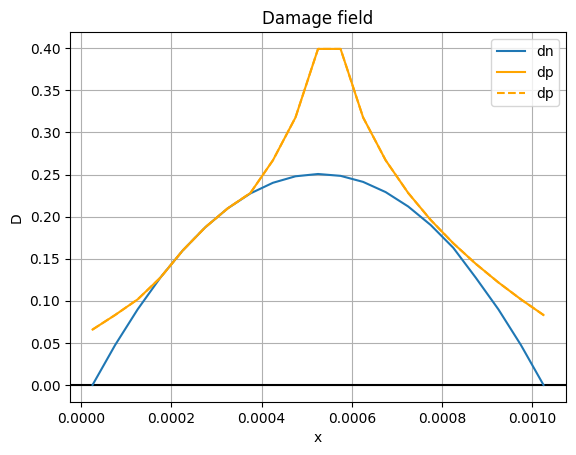

In [104]:
# Plot

def PlotDamage(x, dn, damage_predictor1, damage_predictor2, upper1, lower1, upper2, lower2, upper3, lower3,dlip1, dlip2, dlip3):
    fig, axes = plt.subplots()
    axes.grid(True, which='both')
    axes.axhline(y=0, color='k')

    plt.title(str("Damage field"))
    plt.xlabel(str("x"))
    plt.ylabel(str("D"))
    plt.plot(x, dn, label='dn')
    plt.plot(x, damage_predictor1, label='dp', color='orange')
    plt.plot(x, damage_predictor2, label='dp', color='orange', linestyle = 'dashed')
    # plt.plot(x, upper1, label='upper1', color='red', linestyle = 'dashed')
    # plt.plot(x, lower1, label='lower1', color='green', linestyle = 'dashed')
    # plt.plot(x, upper2, label='upper2', color='red')
    # plt.plot(x, lower2, label='lower2', color='green')
    # plt.plot(x, upper3, label='upper3', color='red', linestyle='dotted')
    # plt.plot(x, lower3, label='lower3', color='green', linestyle='dotted')
    # plt.plot(x, dlip1, label='dlip1', color='black', linestyle = 'dashed')
    # plt.plot(x, dlip2, label='dlip1', color='black')
    # plt.plot(x, dlip3, label='dlip3', color='black', linestyle='dotted')
    plt.legend()
    plt.show()

# PlotDamage(x, dn, dp, upper, lower, d_next, upper_proj, lower_proj)
# PlotDamage(x, dn, damage_predictor, upper_algorithm1, lower_algorithm1, upper_algorithm2, lower_algorithm2, upper_algorithm3, lower_algorithm3, d_next1, d_next2, d_next3)
PlotDamage(x, dn, dp_1, dp_2, 0, 0, 0, 0, 0, 0, 0, 0, 0)